![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [72]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import VotingRegressor #to try diffrent models and pick the best
import matplotlib.pyplot as plt
# Import any additional modules and start coding below
#regression models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor # training the tree better
from sklearn.svm import SVR 

#for festure selection 
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler





In [73]:
df=pd.read_csv('rental_info.csv')
df.head()
#special features is a set of special features 

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [74]:
df.isnull().sum()

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64

In [75]:
#getting the rental days
print(df['rental_date'].dtype)
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])
df['rental_days']=(df['return_date'] - df['rental_date']).dt.days
df['rental_days']

object


0        3
1        2
2        7
3        2
4        4
        ..
15856    6
15857    4
15858    9
15859    8
15860    6
Name: rental_days, Length: 15861, dtype: int64

In [76]:
#encoding the special features
df['special_features'].dtype
def clean_features(cell):
    # Convert the cell to string (just in case)
    s = str(cell)
    # Remove curly braces and quotes as the data is messy 
    for char in ['{', '}', '"', "'"]:
        s = s.replace(char, '')
    # Split by comma
    features = [f.strip() for f in s.split(',') if f.strip() != '']
    return set(features)  # return as a set to avoid duplicates

df['special_features_clean'] = df['special_features'].apply(clean_features)

all_features = set()
for features_set in df['special_features_clean']:
    all_features.update(features_set)

print(all_features)
#encoding with one hot encoder retruning a series of 1,0 indicating this feature exist in this row,theyre all in one row thats why we use this way of encoding
for feature in all_features:
    df[feature] = np.where(df['special_features_clean'].apply(lambda x: feature in x), 1, 0)


#now each feature has its own column
df['Trailers']
df['Commentaries']
df['Deleted Scenes']
df['Behind the Scenes']

{'Trailers', 'Commentaries', 'Deleted Scenes', 'Behind the Scenes'}


0        1
1        1
2        1
3        1
4        1
        ..
15856    1
15857    1
15858    1
15859    1
15860    1
Name: Behind the Scenes, Length: 15861, dtype: int64

In [77]:
#clean and ready to proccess df
df = df.drop(columns=['special_features_clean', 'rental_date', 'return_date'])
df.head()

,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_days,Trailers,Commentaries,Deleted Scenes,Behind the Scenes
0,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,1,0,0,1
1,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,1,0,0,1
2,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,1,0,0,1
3,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,1,0,0,1
4,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,1,0,0,1


In [78]:

df = df.drop(columns=['special_features'])
df.head()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_days,Trailers,Commentaries,Deleted Scenes,Behind the Scenes
0,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,3,1,0,0,1
1,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,1,0,0,1
2,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,7,1,0,0,1
3,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,1,0,0,1
4,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,4,1,0,0,1


In [79]:
#perform feature selection 
X = df.drop(columns=['rental_days'])
y = df['rental_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

#using lasso lets find the most importaint feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
# 2. Fit Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_scaled, y_train)

# 3. Check selected features
selected_features = X_train.columns[lasso.coef_ != 0]
print(selected_features)

Index(['amount', 'rental_rate', 'rental_rate_2'], dtype='object')


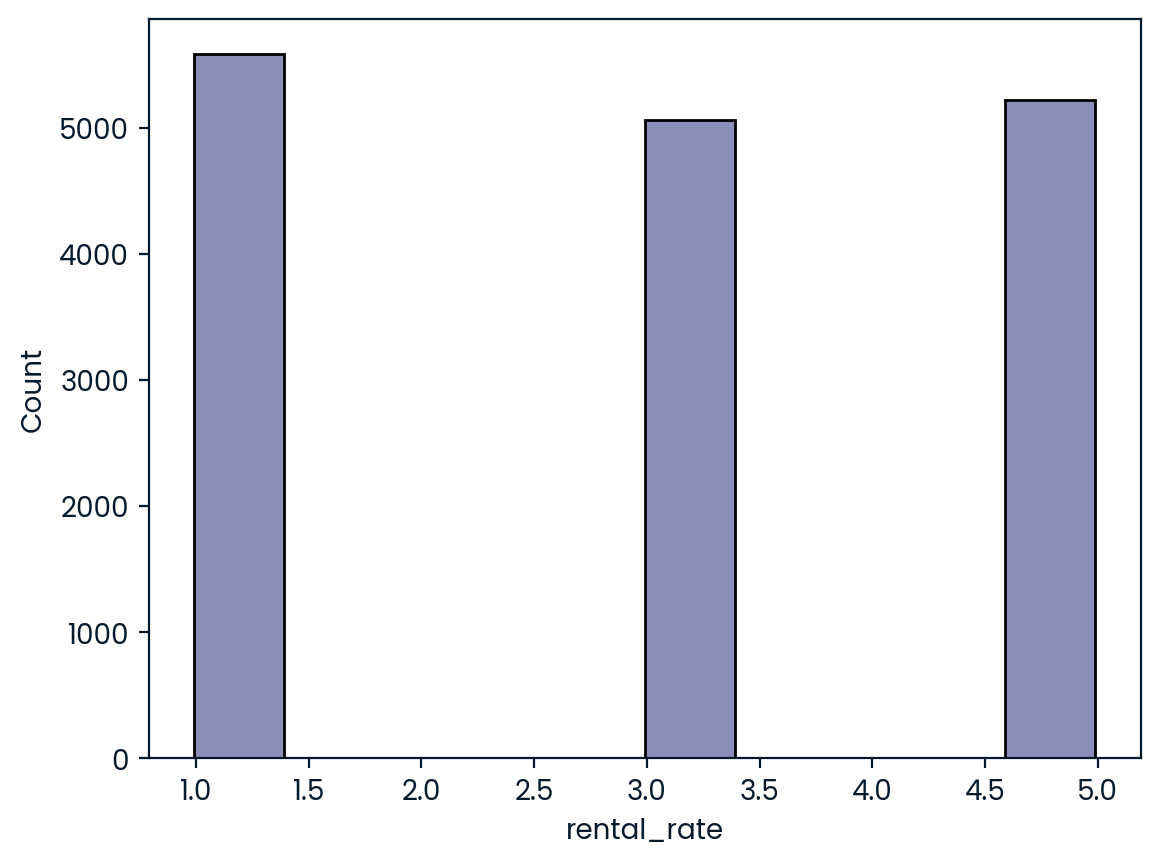

In [80]:
#as the data are simpler i dont think i need to tune alpha currently 
import seaborn as sns
sns.histplot(df['rental_rate'], bins=10, kde=False)
# a non linear trends? lets try non linear regression models

#dropping non important feature 
selected_features = ['amount', 'rental_rate', 'rental_rate_2']
X_train = X_train[selected_features]
X_test = X_test[selected_features]


In [81]:
#define my models
LR=LinearRegression() #keeping it just in case it scores more
LT=DecisionTreeRegressor(max_depth=3,min_samples_leaf=0.12,random_state=9) #needs pramter and ada boosting
treeBoost=AdaBoostRegressor(estimator=LT,n_estimators=300)
SVR_model=SVR()

ensemble = VotingRegressor(
    estimators=[
        ('lr', LR),
        ('treeBoost', treeBoost),
        ('svr', SVR_model)
    ]
)


ensemble.fit(X_train, y_train)


y_pred = ensemble.predict(X_test)

print('voting regressors: {:.3f}'.format(MSE(y_test, y_pred)))

voting regressors: 2.750


In [82]:
print(X.shape)


(15861, 16)
